This notebook is meant to compare the different types of matrix decompositions used for training to see which one works best

In [15]:
%matplotlib inline
import time, sys, math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from multiprocessing.pool import ThreadPool as Pool
sys.path.insert(1, '/home/joeadamo/Research/covariance_emulator')
import covariance_emulator as ce
plt.rcParams['figure.facecolor'] = 'white'

sys.path.insert(1, '/home/joeadamo/Research/CovA-NN-Emulator')
#sys.path.insert(1, '/home/jadamo/CovA-NN-Emulator')
sys.path.append('/home/joeadamo/Research') #<- parent directory of dark emulator code
from DarkEmuPowerRSD import pkmu_nn, pkmu_hod
from CovNet import CovNet

In [17]:
N = 52500
N_PROC = 15
N_test = int(N*0.1)
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set/"
data_dir =  "/home/joeadamo/Research/CovNet/Data/"
PCA_dir = "/home/joeadamo/Research/CovNet/Data/PCA-Set/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [5]:
# data and model vectors for chi squared calculations
# TODO: Replace model vector with Yosuke's emulator output
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
pgg = pkmu_hod()

xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
gparams = {'logMmin': 13.9383, 'sigma_sq': 0.7918725**2, 'logM1': 14.4857, 'alpha': 1.19196,  'kappa': 0.600692, 
          'poff': 0.0, 'Roff': 2.0, 'alpha_inc': 0., 'logM_inc': 0., 'cM_fac': 1., 'sigv_fac': 1., 'P_shot': 0.}

def xi_pi(params, gparams):
    """
    Calculates the model vector using Yosuke's galaxy power spectrum emulator
    """
    h = params[0] / 100
    omch2 = params[1]
    ombh2 = params[2]
    #assert omch2 <= 0.131780
    As = params[3] #torch.log(1e10 * params[3])
    #assert As >= 2.47520
    ns = 0.965
    Om0 = (omch2 + ombh2 + 0.00064) / (h**2)
    
    # rebuild parameters into correct format (ombh2, omch2, 1-Om0, ln As, ns, w)
    cparams = np.array([ombh2, omch2, 1-Om0, As, ns, -1])
    redshift = 0.5
    k = np.linspace(0.005, 0.25, 50)
    mu = np.linspace(0.1,0.9,4)
    alpha_perp = 1.1
    alpha_para = 1

    pgg.set_cosmology(cparams, redshift)
    pgg.set_galaxy(gparams)
    P0_emu = pgg.get_pl_gg_ref(0, k, alpha_perp, alpha_para, name='total')
    P2_emu = pgg.get_pl_gg_ref(2, k, alpha_perp, alpha_para, name='total')
    return np.concatenate((P0_emu, P2_emu))
    
def chi_squared(C, params):
    P = np.linalg.inv(C)
    x = xi_hat - xi_pi(params, gparams)
    return np.matmul(x.T, np.matmul(P, x))

def signal_to_noise(C):
    return 0

initialize cosmo_class
Initialize pklin emulator
initialize propagator emulator
Initialize sigma_d emulator
initialize cross-correlation emulator
initialize auto-correlation emulator
Initialize sigmaM emulator
initialize xinl emulator


We have 3 sets of networks to laod in. 1) networks with no extra data decomposition, 2) networks with Cholesky decomposition, and 3) networks with correlation matrix decomposition

In [18]:
VAE_vanilla     = CovNet.Network_VAE().to(CovNet.try_gpu());      VAE_vanilla.eval()
VAE_cholesky    = CovNet.Network_VAE(True).to(CovNet.try_gpu());  VAE_cholesky.eval()
VAE_correlation = CovNet.Network_VAE().to(CovNet.try_gpu());      VAE_correlation.eval()
decoder_vanilla     = CovNet.Block_Decoder().to(CovNet.try_gpu());     decoder_vanilla.eval()
decoder_cholesky    = CovNet.Block_Decoder(True).to(CovNet.try_gpu()); decoder_cholesky.eval()
decoder_correlation = CovNet.Block_Decoder().to(CovNet.try_gpu());     decoder_correlation.eval()
net_vanilla     = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net_cholesky    = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net_correlation = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())

VAE_vanilla.load_state_dict(torch.load(data_dir+'No-decomp/network-VAE.params', map_location=CovNet.try_gpu()))
VAE_cholesky.load_state_dict(torch.load(data_dir+'Cholesky-decomp/network-VAE.params', map_location=CovNet.try_gpu()))
VAE_correlation.load_state_dict(torch.load(data_dir+'Correlation-decomp/network-VAE.params', map_location=CovNet.try_gpu()))
decoder_vanilla.load_state_dict(VAE_vanilla.Decoder.state_dict())
decoder_cholesky.load_state_dict(VAE_cholesky.Decoder.state_dict())
decoder_correlation.load_state_dict(VAE_correlation.Decoder.state_dict())
net_vanilla.load_state_dict(torch.load(data_dir+"No-decomp/network-features.params", map_location=CovNet.try_gpu()))
net_cholesky.load_state_dict(torch.load(data_dir+"Cholesky-decomp/network-features.params", map_location=CovNet.try_gpu()))
net_correlation.load_state_dict(torch.load(data_dir+"Correlation-decomp/network-features.params", map_location=CovNet.try_gpu()))

<All keys matched successfully>

In [19]:
# Load in all the quad networks (there are lots so I split this into its own cell)
net_q1 = CovNet.Network_VAE_Quad(50, True).to(CovNet.try_gpu()); net_q2 = CovNet.Network_VAE_Quad(50, True).to(CovNet.try_gpu()); net_q3 = CovNet.Network_VAE_Quad(50, False).to(CovNet.try_gpu())
decoder_q1 = CovNet.Block_Decoder_Quad(50, True).to(CovNet.try_gpu()); decoder_q2 = CovNet.Block_Decoder_Quad(50, True).to(CovNet.try_gpu()); decoder_q3 = CovNet.Block_Decoder_Quad(50, False).to(CovNet.try_gpu())
net_f1 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu()); net_f2 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu()); net_f3 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
decoder_q1.eval(); decoder_q2.eval(); decoder_q3.eval(); net_f1.eval(); net_f2.eval(); net_f3.eval()

net_q1.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q1.params", map_location=CovNet.try_gpu()))
net_q2.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q2.params", map_location=CovNet.try_gpu()))
net_q3.load_state_dict(torch.load(data_dir+"Quad-decomp/network-VAE-q3.params", map_location=CovNet.try_gpu()))          
decoder_q1.load_state_dict(net_q1.Decoder.state_dict()); decoder_q2.load_state_dict(net_q2.Decoder.state_dict()); decoder_q3.load_state_dict(net_q3.Decoder.state_dict())
net_f1.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q1.params", map_location=CovNet.try_gpu()))
net_f2.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q2.params", map_location=CovNet.try_gpu()))
net_f3.load_state_dict(torch.load(data_dir+"Quad-decomp/network-latent-q3.params", map_location=CovNet.try_gpu()))   

<All keys matched successfully>

In [20]:
# load the VALIDATION set
# Since this notebook is mostly checking what model works best, we don't want to use the test set to prevent overfitting
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.8), False, False, False)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 1.98 s


Now let's setup the PCA emulator

In [21]:
N_C = 100
C_PCA = np.zeros((N_C, 100, 100))
params_PCA = np.zeros((N_C, 6))
for i in range(N_C):
    temp = np.load(PCA_dir+"CovA-"+f'{i:04d}'+".npz")
    params_PCA[i] = np.delete(temp["params"], 4)
    C_PCA[i] = torch.from_numpy(temp["C"])
    
    # if the matrix doesn't match the transpose close enough, manually flip over the diagonal
    try:
        np.testing.assert_allclose(C_PCA[i], C_PCA[i].T, err_msg="covariance must match transpose")
    except AssertionError:
        print("matrix", i, "has high assymetry!")
        L = np.tril(C_PCA[i])
        U = np.tril(C_PCA[i], k=-1).T
        C_PCA[i] = L + U

matrix 14 has high assymetry!
matrix 20 has high assymetry!
matrix 52 has high assymetry!
matrix 73 has high assymetry!
matrix 74 has high assymetry!
matrix 83 has high assymetry!
matrix 91 has high assymetry!


In [22]:
Emu = ce.CovEmu(params_PCA, C_PCA, NPC_D=20, NPC_L=20)

Now let's calculate the $\chi^2$ errors for each of these networks and the PCA emulator

In [23]:
# error_vanilla, error_cholesky, error_correlation, error_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# SN_true, SN_diff_vanilla, SN_diff_cholesky, SN_diff_corr, SN_diff_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# Loss_vanilla, Loss_cholesky, Loss_corr, Loss_quad, Loss_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
# def get_net_info(idx):
#     C = test_data[idx][1]
#     params = test_data[idx][0]

#     features = net_vanilla(params);     C_vanilla = decoder_vanilla(features.view(1,10)).view(100, 100)
#     C_vanilla = CovNet.symmetric_exp(C_vanilla)
#     features = net_cholesky(params);    C_cholesky = decoder_cholesky(features.view(1,10)).view(100, 100)
#     C_cholesky = torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))
#     features = net_correlation(params); C_correlation = decoder_correlation(features.view(1,10)).view(100, 100)
#     C_correlation = CovNet.corr_to_cov(C_correlation)
#     C_quad = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params).view(100,100)
#     C_quad = CovNet.symmetric_exp(C_quad)
#     C_PCA = Emu.predict(params.to("cpu").detach().numpy())

#     Loss_vanilla[idx] = F.l1_loss(C_vanilla, C, reduction="sum")
#     Loss_cholesky[idx] = F.l1_loss(C_cholesky, C, reduction="sum")
#     Loss_corr[idx] = F.l1_loss(C_correlation, C, reduction="sum")
#     Loss_quad[idx] = F.l1_loss(C_quad, C, reduction="sum")
#     Loss_PCA[idx] = F.l1_loss(torch.from_numpy(C_PCA).to(CovNet.try_gpu()), C, reduction="sum")

#     try:
#         chisq = chi_squared(C.cpu(), params)
#         chisq_vanilla = chi_squared(C_vanilla.to("cpu").detach().numpy(), params)
#         chisq_cholesky = chi_squared(C_cholesky.to("cpu").detach().numpy(), params)
#         chisq_correlation = chi_squared(C_correlation.to("cpu").detach().numpy(), params)
#         chisq_PCA = chi_squared(C_PCA, params)
#     except AssertionError:
#         return error_vanilla

#     SN = signal_to_noise(C.cpu())
#     SN_vanilla = signal_to_noise(C_vanilla.to("cpu").detach().numpy())
#     SN_cholesky = signal_to_noise(C_cholesky.to("cpu").detach().numpy())
#     SN_correlation = signal_to_noise(C_correlation.to("cpu").detach().numpy())
#     SN_PCA = signal_to_noise(C_PCA)

#     error_vanilla[idx] = abs(chisq - chisq_vanilla)
#     error_cholesky[idx] = abs(chisq - chisq_cholesky)
#     error_correlation[idx] = abs(chisq - chisq_correlation)
#     error_PCA[idx] = abs(chisq - chisq_PCA)
#     SN_true[idx] = SN
#     SN_diff_vanilla[idx] = SN_vanilla - SN
#     SN_diff_cholesky[idx] = SN_cholesky - SN
#     SN_diff_corr[idx] = SN_correlation - SN
#     SN_diff_PCA[idx] = SN_PCA - SN
    
    # return error_vanilla

In [29]:
# WARNING: this cell takes over an hour to run when doing the chi squared
t1 = time.time()
error_vanilla, error_cholesky, error_correlation, error_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
SN_true, SN_diff_vanilla, SN_diff_cholesky, SN_diff_corr, SN_diff_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
Loss_vanilla, Loss_cholesky, Loss_corr, Loss_quad, Loss_PCA = np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test), np.zeros(N_test)
for idx in range(N_test):
    C = test_data[idx][1]
    params = test_data[idx][0]

    features = net_vanilla(params);     C_vanilla = decoder_vanilla(features.view(1,10)).view(100, 100)
    C_vanilla = CovNet.symmetric_exp(C_vanilla)
    features = net_cholesky(params);    C_cholesky = decoder_cholesky(features.view(1,10)).view(100, 100)
    C_cholesky = torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))
    features = net_correlation(params); C_correlation = decoder_correlation(features.view(1,10)).view(100, 100)
    C_correlation = CovNet.corr_to_cov(C_correlation)
    C_quad = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params).view(100,100)
    C_quad = CovNet.symmetric_exp(C_quad)
    C_PCA = Emu.predict(params.to("cpu").detach().numpy())

    Loss_vanilla[idx] = F.l1_loss(C_vanilla, C, reduction="sum")
    Loss_cholesky[idx] = F.l1_loss(C_cholesky, C, reduction="sum")
    Loss_corr[idx] = F.l1_loss(C_correlation, C, reduction="sum")
    Loss_quad[idx] = F.l1_loss(C_quad, C, reduction="sum")
    Loss_PCA[idx] = F.l1_loss(torch.from_numpy(C_PCA).to(CovNet.try_gpu()), C, reduction="sum")

#     try:
#         chisq = chi_squared(C.cpu(), params)
#         chisq_vanilla = chi_squared(C_vanilla.to("cpu").detach().numpy(), params)
#         chisq_cholesky = chi_squared(C_cholesky.to("cpu").detach().numpy(), params)
#         chisq_correlation = chi_squared(C_correlation.to("cpu").detach().numpy(), params)
#         chisq_PCA = chi_squared(C_PCA, params)
#     except AssertionError:
#         continue

#     SN = signal_to_noise(C.cpu())
#     SN_vanilla = signal_to_noise(C_vanilla.to("cpu").detach().numpy())
#     SN_cholesky = signal_to_noise(C_cholesky.to("cpu").detach().numpy())
#     SN_correlation = signal_to_noise(C_correlation.to("cpu").detach().numpy())
#     SN_PCA = signal_to_noise(C_PCA)

#     error_vanilla[idx] = abs(chisq - chisq_vanilla)
#     error_cholesky[idx] = abs(chisq - chisq_cholesky)
#     error_correlation[idx] = abs(chisq - chisq_correlation)
#     error_PCA[idx] = abs(chisq - chisq_PCA)
#     SN_true[idx] = SN
#     SN_diff_vanilla[idx] = SN_vanilla - SN
#     SN_diff_cholesky[idx] = SN_cholesky - SN
#     SN_diff_corr[idx] = SN_correlation - SN
#     SN_diff_PCA[idx] = SN_PCA - SN
    
# idx = range(15)
# with Pool(processes=N_PROC) as pool:
#     error_vanilla = pool.starmap(get_net_info, zip(idx))

# print(error_vanilla[0], error_vanilla.shape)
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 7 minutes 59.58 seconds


/home/joeadamo/virtual-enviornments/cov-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/joeadamo/virtual-enviornments/cov-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


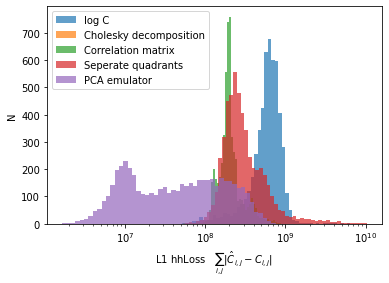

In [30]:
plt.hist(Loss_vanilla, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_vanilla)), np.log10(np.amax(Loss_vanilla)), 50), label="log C")
plt.hist(Loss_cholesky, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_cholesky)), np.log10(np.amax(Loss_cholesky)), 50), label="Cholesky decomposition")
plt.hist(Loss_corr, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_corr)), np.log10(np.amax(Loss_corr)), 50), label="Correlation matrix")
plt.hist(Loss_quad, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_quad)), np.log10(np.amax(Loss_quad)), 50), label="Seperate quadrants")
plt.hist(Loss_PCA, alpha=0.7, bins=np.logspace(np.log10(np.amin(Loss_PCA)), np.log10(np.amax(Loss_PCA)), 50), label="PCA emulator")
plt.xlabel(r"L1 hhLoss   $\sum_{i,j} |\hat{C}_{i,j} - C_{i,j}|$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()

In [ ]:
#error_vanilla = error_vanilla[(error_vanilla > 0)]
#error_cholesky = error_cholesky[(error_cholesky > 0)]
#error_correlation = error_correlation[(error_correlation > 0)]
#error_PCA = error_PCA[(error_PCA > 0)]
print(len(error_vanilla), np.amin(error_vanilla), np.amax(error_vanilla))
plt.hist(error_vanilla, bins=np.logspace(np.log10(np.amin(error_vanilla)), np.log10(np.amax(error_vanilla)), 50), alpha=0.5, label="log C")
plt.hist(error_cholesky, bins=np.logspace(np.log10(np.amin(error_cholesky)), np.log10(np.amax(error_cholesky)), 50), alpha=0.5, label="Cholesky Decomposition")
plt.hist(error_correlation, bins=np.logspace(np.log10(np.amin(error_correlation)), np.log10(np.amax(error_correlation)), 50), alpha=0.5, label="Correlation Matrix")
plt.hist(error_PCA, bins=np.logspace(np.log10(np.amin(error_PCA)), np.log10(np.amax(error_PCA)), 50), alpha=0.5, label="PCA Emulator")
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")
plt.legend()
# TODO: find metrics to measure how well we're doing
# S/N = x C^-1 x.T <- take sqrt = signal to noise - can find difference in S?N from using different C
# create maps of S/N with a few of the parameters
# try emulating quadrants seperately

Let's look at each network on an individual matrix level to see how they're doing

In [ ]:
# Check that matrices with 2 different cosmologies are different
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
C_1 = test_data[idx1][1]; C_2 = test_data[idx2][1]

features = net_vanilla(params1);     C_vanilla1 = decoder_vanilla(features.view(1,10)).view(100, 100)
features = net_vanilla(params2);     C_vanilla2 = decoder_vanilla(features.view(1,10)).view(100, 100)
C_vanilla1 = CovNet.symmetric_exp(C_vanilla1);  C_vanilla2 = CovNet.symmetric_exp(C_vanilla2)
features = net_cholesky(params1);    C_cholesky1 = decoder_cholesky(features.view(1,10)).view(100, 100)
features = net_cholesky(params2);    C_cholesky2 = decoder_cholesky(features.view(1,10)).view(100, 100)
C_cholesky1 = torch.matmul(CovNet.symmetric_exp(C_cholesky1), torch.t(CovNet.symmetric_exp(C_cholesky1)))
C_cholesky2 = torch.matmul(CovNet.symmetric_exp(C_cholesky2), torch.t(CovNet.symmetric_exp(C_cholesky2)))
features = net_correlation(params1); C_correlation1 = decoder_correlation(features.view(1,10)).view(100, 100)
features = net_correlation(params2); C_correlation2 = decoder_correlation(features.view(1,10)).view(100, 100)
C_correlation1 = CovNet.corr_to_cov(C_correlation1); C_correlation2 = CovNet.corr_to_cov(C_correlation2)
C_PCA1 = Emu.predict(params1.to("cpu").detach().numpy())
C_PCA2 = Emu.predict(params2.to("cpu").detach().numpy())
C_quad1 = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params1).view(100,100)
C_quad2 = CovNet.predict_quad(decoder_q1, decoder_q2, decoder_q3, net_f1, net_f2, net_f3, params2).view(100,100)

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:"+ str(idx1) +",", idx2)
fig, axs = plt.subplots(3, 2, figsize=(9,12))
fig.suptitle("Differences between cosmologies")
axs[0,0].set_title("CovaPT")
axs[0,1].set_title("log C")
axs[1,0].set_title("Cholesky decomp")
axs[1,1].set_title("Correlation matrix")
axs[2,0].set_title("PCA Emulator")
axs[2,1].set_title("Seperate Quadrants")
m = axs[0,0].imshow(abs(C_1 - C_2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[0,0])
m = axs[0,1].imshow(abs(C_vanilla1 - C_vanilla2).cpu().detach().numpy(), vmin=torch.amin(abs(C_1 - C_2)), vmax=torch.amax(abs(C_1 - C_2)))
fig.colorbar(m, ax=axs[0,1])
m = axs[1,0].imshow(abs(C_cholesky1 - C_cholesky2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,0])
m = axs[1,1].imshow(abs(C_correlation1 - C_correlation2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[1,1])
m = axs[2,0].imshow(abs(C_PCA1 - C_PCA2))
fig.colorbar(m, ax=axs[2,0])
m = axs[2,1].imshow(abs(C_quad1 - C_quad2).cpu().detach().numpy())
fig.colorbar(m, ax=axs[2,1])

#axs[-1, -1].axis('off')
fig.tight_layout()
fig.subplots_adjust(top=0.94)

print(F.l1_loss(C_vanilla1, C_1, reduction="sum"))
print(VAE_loss(C_vanilla1, C_1, torch.tensor([0]), torch.tensor([1]), 0))

Let's also look at the training + validation loss graphs to make sure nothing fishy is going on

In [ ]:
train_loss_vanilla = torch.load(data_dir+"No-decomp/train_loss.dat")
valid_loss_vanilla = torch.load(data_dir+"No-decomp/valid_loss.dat")
train_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss.dat")
valid_loss_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss.dat")
train_loss_correlation = torch.load(data_dir+"Correlation-decomp/train_loss.dat")
valid_loss_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss.dat")
train_loss_f_vanilla = torch.load(data_dir+"No-decomp/train_loss-features.dat")
valid_loss_f_vanilla = torch.load(data_dir+"No-decomp/valid_loss-features.dat")
train_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/train_loss-features.dat")
valid_loss_f_cholesky = torch.load(data_dir+"Cholesky-decomp/valid_loss-features.dat")
train_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/train_loss-features.dat")
valid_loss_f_correlation = torch.load(data_dir+"Correlation-decomp/valid_loss-features.dat")
loss_data_quad = torch.load(data_dir+"Quad-decomp/loss_data.dat")
loss_data_f_quad = torch.load(data_dir+"Quad-decomp/loss_data-features.dat")

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Log C")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_vanilla, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_vanilla, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_vanilla, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_vanilla, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Cholesky Decomposition")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_cholesky, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_cholesky, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_cholesky, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_cholesky, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Correlation Matrix")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(60), train_loss_correlation, color="blue", label="training loss")
axs[0].plot(range(60), valid_loss_correlation, color="red", ls="--", label="validation loss")
axs[1].plot(range(130), train_loss_f_correlation, color="blue", label="training loss")
axs[1].plot(range(130), valid_loss_f_correlation, color="red", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(10, 100)
axs[1].set_xlabel("epoch")
axs[0].legend()

fig, axs = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("Correlation Matrix")
axs[0].set_title("VAE Network")
axs[1].set_title("features Network")
axs[0].plot(range(75), loss_data_quad[0,:], color="blue", label=r"$C_{0,0}$ quadrant")
axs[0].plot(range(75), loss_data_quad[1,:], color="red", label=r"$C_{2,2}$ quadrant")
axs[0].plot(range(75), loss_data_quad[2,:], color="green", label=r"$C_{0,2}$ quadrant")
axs[0].plot(range(75), loss_data_quad[3,:], color="blue", ls="--", label="validation loss")
axs[0].plot(range(75), loss_data_quad[4,:], color="red", ls="--")
axs[0].plot(range(75), loss_data_quad[5,:], color="green", ls="--")
axs[1].plot(range(130), loss_data_f_quad[0,:], color="blue", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[1,:], color="red", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[2,:], color="green", label="training loss")
axs[1].plot(range(130), loss_data_f_quad[3,:], color="blue", ls="--", label="validation loss")
axs[1].plot(range(130), loss_data_f_quad[4,:], color="red", ls="--", label="validation loss")
axs[1].plot(range(130), loss_data_f_quad[5,:], color="green", ls="--", label="validation loss")
axs[0].set_xlabel("epoch")
#axs[0].set_ylim(10, 100)
axs[1].set_xlabel("epoch")
axs[0].legend()

Let's look at how similar the training matrices are for each decomposition type, as matrices that are almost identical are going to be difficult for any neural network to distinguish between

In [ ]:
from CovNet import rearange_to_half
M = 200

def cov_to_corr(C):
    D = torch.diag_embed(torch.sqrt(torch.diag(C)))
    Corr = torch.matmul(torch.linalg.inv(D), torch.matmul(C, torch.linalg.inv(D)))
    return Corr + (symmetric_log(D) - torch.eye(100))

t1 = time.time()
L_vanilla, L_cholesky, L_corr = np.zeros((M,M)), np.zeros((M,M)), np.zeros((M,M))
for i in range(M):
    C_1 = test_data[i][1].view(1,100,100)
    L_1 = torch.linalg.cholesky(C_1)
    Corr_1 = cov_to_corr(C_1.view(100,100)).view(1,100,100)
    
    #C_1 = rearange_to_half(C_1)
    #L_1 = rearange_to_half(L_1)
    #Corr_1 = rearange_to_half(Corr_1)
    
    for j in range(M):
        C_2 = test_data[j][1].view(1,100,100)
        L_2 = torch.linalg.cholesky(C_2)
        Corr_2 = cov_to_corr(C_2.view(100,100)).view(1,100,100)

        #C_2 = rearange_to_half(C_2)
        #L_2 = rearange_to_half(L_2)
        #Corr_2 = rearange_to_half(Corr_2)
    
        # Since the network uses the L1 loss function to determine distance, let's use it to measure that here as well
        L_vanilla[i,j] = F.l1_loss(C_1, C_2, reduction="sum")
        L_cholesky[i,j] = F.l1_loss(L_1, L_2, reduction="sum")
        L_corr[i,j] = F.l1_loss(Corr_1, Corr_2, reduction="sum")
    
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

In [ ]:
plt.imshow(L_vanilla)
plt.title("'defaul' matrix type")
cbar = plt.colorbar()

plt.figure()
plt.title("cholesky decomposition")
plt.imshow(L_cholesky)
cbar = plt.colorbar()

plt.figure()
plt.title("correlation decomposition")
plt.imshow(L_corr)
cbar = plt.colorbar()

In [ ]:
mu_v, med_v = np.mean(L_vanilla), np.median(L_vanilla)
mu_l, med_l = np.mean(L_cholesky), np.median(L_cholesky)
mu_c, med_c = np.mean(L_corr), np.median(L_corr)
print("mean + var (log C)    = {:0.3f},  {:0.3f}".format(mu_v, med_v))
print("mean + var (cholesky) = {:0.3f},  {:0.3f}".format(mu_l, med_l))
print("mean + var (corr)     = {:0.3f},  {:0.3f}".format(mu_c, med_c))

In [ ]:
# Signal to noise is calculated using equation 8 in Wadeckar et al 2020
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

In [ ]:
params = test_data[:][0].cpu().detach().numpy()
H0 = params[:,0]; Omega_m = params[:,1]; As = params[:,2]

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$\hat{\xi}^T C_{CovaPT}^{-1} \hat{\xi}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_true, 40)
m = axs[0,0].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_true, 40)
m = axs[1,0].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_true, 40)
m = axs[1,1].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$S/N_{net} - S/N_{CovaPT}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_diff_vanilla, 40)
m = axs[0,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_diff_vanilla, 40)
m = axs[1,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_diff_vanilla, 40)
m = axs[1,1].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

fig, axs = plt.subplots(2,2, figsize=(9,8))
fig.suptitle(r"$S/N_{PCA} - S/N_{CovaPT}$")
X, Y, Z = make_heatmap(H0, Omega_m, SN_diff_PCA, 40)
m = axs[0,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[0,0], label="S/N")

X, Y, Z = make_heatmap(H0, As, SN_diff_PCA, 40)
m = axs[1,0].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,0], label="S/N")

X, Y, Z = make_heatmap(Omega_m, As, SN_diff_PCA, 40)
m = axs[1,1].imshow(Z, aspect="auto", cmap="RdBu", extent=(X[0], X[-1], Y[0], Y[-1]))
fig.colorbar(m, ax=axs[1,1], label="S/N")
axs[0,0].set_ylabel(r"$\Omega_m$")
axs[1,0].set_xlabel(r"$H_0$")
axs[1,0].set_ylabel(r"$A_0$")
axs[1,1].set_xlabel(r"$\Omega_m$")
fig.tight_layout()
axs[0, 1].axis('off')

In [ ]:
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
features = net_cholesky(params);    C_cholesky = decoder_cholesky(features.view(1,10)).view(100, 100)
#C_cholesky = symmetric_log(torch.matmul(CovNet.symmetric_exp(C_cholesky), torch.t(CovNet.symmetric_exp(C_cholesky)))).cpu().detach().numpy()
C_cholesky = C_cholesky.cpu().detach().numpy()
plt.imshow(C_cholesky, cmap="RdBu")